# Advanced Lane Finding
## P4 Self Driving Car Nanodegree

### Importing libraries

In [1]:
import cv2
import numpy as np
import os
import glob
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from tkinter import *
from PIL import Image,ImageTk
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
%matplotlib inline

In [2]:
## patterns and test images paths. 
patterns_path = 'camera_cal'
test_images_path = 'test_images'
patterns_fn = glob.glob(os.path.join(os.getcwd(),patterns_path, 'calibration*.jpg'))
test_images_fn = glob.glob(os.path.join(os.getcwd(),test_images_path, '*.jpg'))

# Camera calibration

In [3]:
def get_obj_and_img_points(patterns_fn, nx = 9,ny = 6, display = False):
    """function to get the obj poinst and img points for a given set of images paths"""
    obj_points = []
    img_points = []
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    for i in tqdm(range(len(patterns_fn))):
        fn = patterns_fn[i]
        img = cv2.imread(fn)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            img_points.append(corners)
            obj_points.append(objp)
            if display:
                plt.figure()
                cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                plt.imshow(img)
    return obj_points, img_points


100%|██████████████████████████████████████████| 20/20 [00:11<00:00,  1.68it/s]


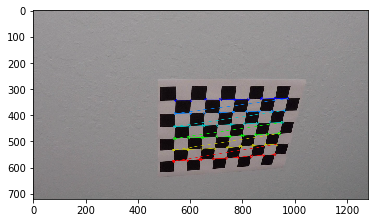

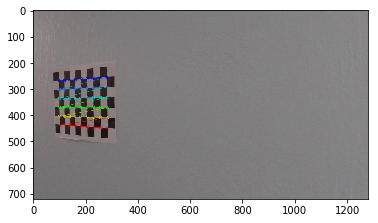

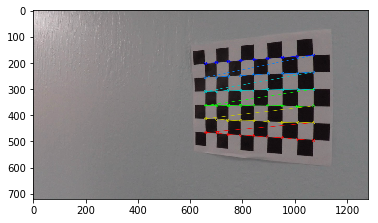

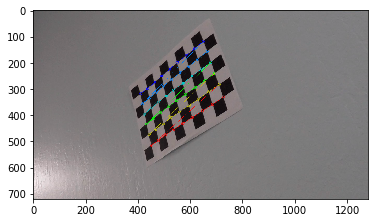

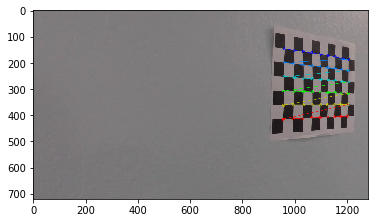

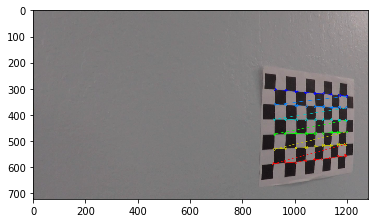

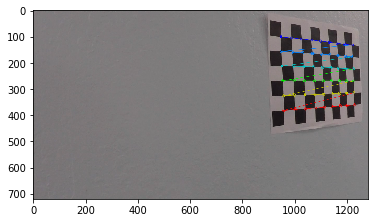

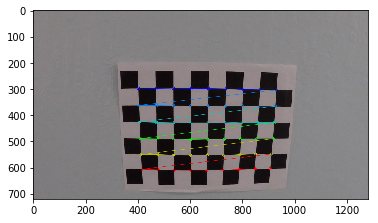

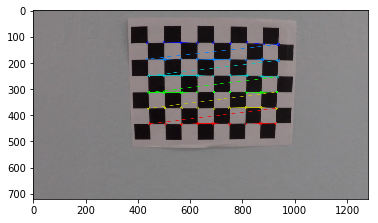

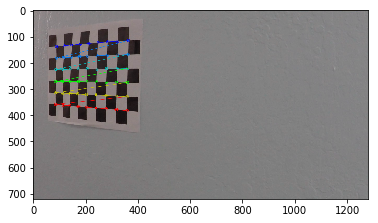

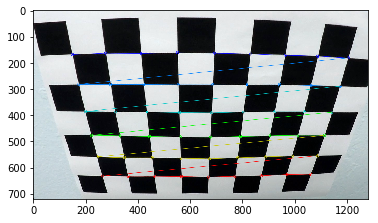

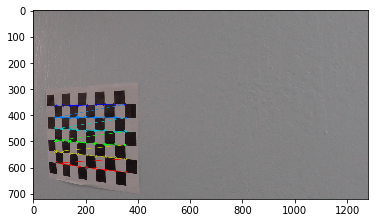

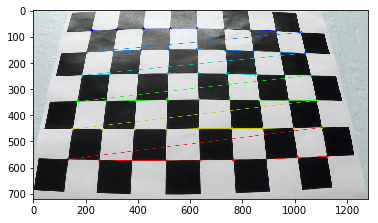

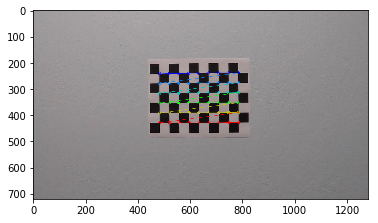

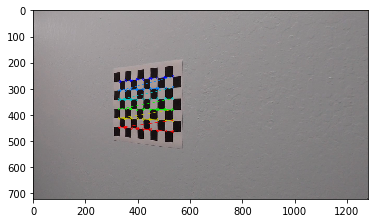

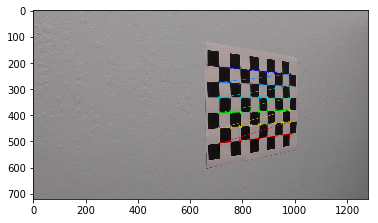

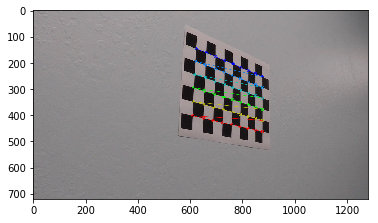

In [4]:
_,_ = get_obj_and_img_points(patterns_fn, display = True)

Obtaining calibration and distortion matrices and save them

In [5]:
try:
    calibration_params = pickle.load(open('calibration_parameters.p', 'rb'))
    print('parameters loaded successfully')
except:
    obj_points, img_points = get_obj_and_img_points(patterns_fn)
    ret, mtx, dist, _, _  = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1],None,None)
    calibration_params = dict([('mtx', mtx), ('dist', dist)])
    pickle.dump(calibration_params, open('calibration_parameters.p', 'wb'))
    print('parameters saved successfully')


parameters loaded successfully


In [6]:
def undistort(image, mtx = calibration_params['mtx'], dist = calibration_params['dist']):
    """simplified undistort function"""
    return cv2.undistort(image, calibration_params['mtx'], calibration_params['dist'], None, calibration_params['mtx'])

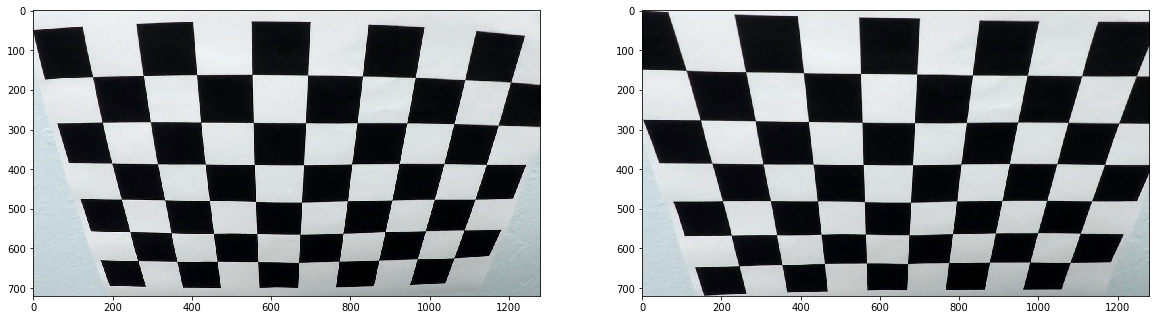

In [7]:
"""example of successful undistortion"""
test_image = cv2.imread(os.path.join(os.getcwd(), patterns_path, 'calibration2.jpg'))
plt.figure(figsize = (20,10))
plt.subplot(121)
plt.imshow(test_image)
undist = undistort(test_image)
plt.subplot(122)
plt.imshow(undist)
plt.show()

In [8]:
class FramePopUp():
    """interactive pop up window to get coordinates of interest in order to perform a correct perspective transformation"""
    def __init__(self, input_img):
        self.root = Tk()
        self.width = input_img.shape[1]
        self.height = input_img.shape[0]
        self.frame = Frame(self.root, bd=2, relief=SUNKEN)
        self.frame.grid_rowconfigure(0, weight=1)
        self.frame.grid_columnconfigure(0, weight=1)
        self.canvas = Canvas(self.frame, bd=0, width = self.width, height = self.height)
        self.canvas.grid(row=0, column=0, sticky=N+S+E+W)
        self.frame.pack(fill=BOTH,expand=1)
        self.img = ImageTk.PhotoImage(Image.fromarray(input_img))
        self.canvas.create_image(0,0,image=self.img,anchor="nw")
        self.canvas.bind("<Button 1>",self.savecoords)
        self.src_points = []
        self.click_count = 0
        mainloop()
        
    def savecoords(self,event):
        # Save each coordinate, also display helping guide lines
        self.click_count += 1
        if self.click_count>4:
            self.root.destroy()
            return
        if self.click_count%2 == 1:
            self.canvas.create_line(0, event.y, self.width, event.y)
            self.src_points.append([event.x/self.width , event.y/self.height])
        else:
            self.src_points.append([event.x/self.width, self.src_points[-1][1]])
        self.canvas.create_oval(self.src_points[-1][0]*self.width-2,
                                self.src_points[-1][1]*self.height-2,
                                self.src_points[-1][0]*self.width+2,
                                self.src_points[-1][1]*self.height+2, fill = 'green')
        
    def get_values(self):
        return self.src_points


In [9]:
#saving and loading the source points
try:
    src_points = pickle.load(open('source_points.p', 'rb'))
    print('parameters loaded successfully')
except:
    img = undistort(cv2.imread(os.path.join(os.getcwd(), test_images_path, 'straight_lines2.jpg')))
    framePopUp = FramePopUp(img)
    src_points = np.float32(framePopUp.get_values())
    pickle.dump(src_points, open('source_points.p', 'wb'))
    print('parameters saved successfully')


parameters loaded successfully


In [10]:
def get_perspective_matrix(input_img, src_points,dst_points):
    # get the perspective transform matrix and the inverse perspective transform matrix
    h, w = input_img.shape[0], input_img.shape[1]
    src = np.float32([[w,h],
                    [w,h],
                    [w,h],
                    [w,h]])*src_points
    dst = np.float32([[w,h],
                    [w,h],
                    [w,h],
                    [w,h]])*dst_points
    return cv2.getPerspectiveTransform(src,dst), cv2.getPerspectiveTransform(dst,src)
    
def change_to_bird_eye(input_img, M):
    #change an image with the corrseponding transform matrix, it keeps the original image dimensions
    h, w = input_img.shape[0], input_img.shape[1]
    return cv2.warpPerspective(input_img, M, (w, h))


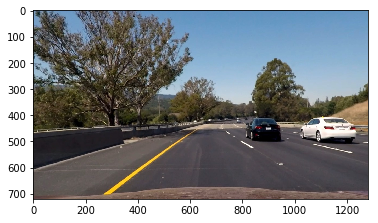

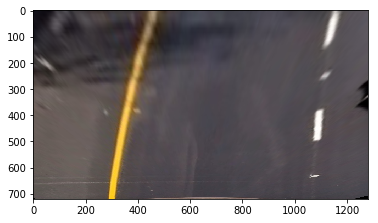

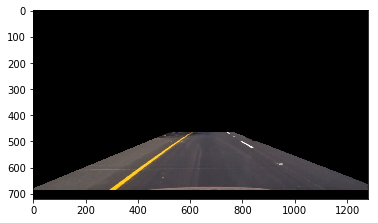

In [11]:
# fixed destination points
dst_points = np.float32([[0.2,0],[0.8,0],[0.2,1],[0.8,1]])
# undistort the image
img = undistort(cv2.imread(os.path.join(os.getcwd(), test_images_path, 'test6.jpg')))
# convert it to rgb
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# display the original and the transformed image
w, h = img.shape[1], img.shape[0]
M, Minv = get_perspective_matrix(img, src_points,dst_points)
bird_eye_view = change_to_bird_eye(img, M)
plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(bird_eye_view)
plt.show()
plt.figure()
plt.imshow(cv2.warpPerspective(bird_eye_view, Minv, (w, h)))
plt.show()

In [12]:
def gaussmf(x,thresh = (0,255), mean = None, sigma = None, type = 'int32'):
    # gauss member function it return a certainty for each pixel given a threshold or mean an sigma values
    if mean == None:
        mean = np.mean(thresh)
    if sigma == None:
        sigma = thresh[1]- thresh[0]
    return np.exp(-((x.astype(type)-mean)**2.)/float(sigma)**2.)

def mag_thresh(input_img, sobel_kernel=3, mag_thresh=(0, 255), fuzzy = True):

    # 1) Convert to grayscale
    gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2+sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    if fuzzy:
        binary_output = gaussmf(scaled_sobel,mag_thresh, type = 'float32').astype(np.float32)
        # return a fuzzy mask
    else:
        binary_output = np.zeros_like(scaled_sobel)
        # 6) Return this mask as your binary_output image

        binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])]  = 1
    return binary_output

def dir_threshold(input_img, sobel_kernel=3, thresh=(0, np.pi/2), mean = None, sigma = None,fuzzy = True):
    # Convert to grayscale
    gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize = sobel_kernel)
    # Calculate the orientation
    abs_x = np.absolute(sobelx)
    abs_y = np.absolute(sobely)
    orientation = np.arctan2(abs_y, abs_x)
    if fuzzy:
        binary_output = gaussmf(orientation,thresh, mean, sigma, type = 'float32').astype(np.float32)
        # return a fuzzy mask
    else:
        binary_output = np.zeros_like(orientation)
        binary_output[(orientation >= thresh[0]) & (orientation <= thresh[1])] = 1
        #return a binary mask
        
    return binary_output

def abs_sobel_thresh(input_img, orient='x', thresh=(0,255), sobel_kernel=3, fuzzy = True):
    gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, orient == 'x', orient == 'y', ksize = sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    if fuzzy:
        binary_output = gaussmf(scaled_sobel,thresh, type = 'float32').astype(np.float32).astype(np.float32)
    else:
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] =  1
    return binary_output

def manual_conv_thresh(input_img, top = 0.3, bottom = 0.14, fuzzy = True): 
    gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
    #HLS = cv2.cvtColor(input_img, cv2.COLOR_BGR2HLS)
    high = np.zeros_like(gray)
    low = np.zeros_like(gray)
    weights = np.linspace(top,bottom,gray.shape[0])
    for i, row in enumerate(gray): 
        high[i,:] = np.convolve(gray[i,:],[-weights[i],-1,-weights[i]], 'same')
        low[i,:] = np.convolve(gray[i,:],[-weights[i],-.1,-weights[i]], 'same')
    if fuzzy:
        binary_output = np.maximum(gaussmf(high,(200,255), type = 'float32'),gaussmf(low,(0,180), type = 'float32')).astype(np.float32)
    else:
        binary_output = np.bitwise_or(high>200,low<180).astype('int')
    return binary_output

def combined_thresholds(input_img, display = False):
    ksize = 5
    gradx = abs_sobel_thresh(input_img, orient='x', sobel_kernel=ksize, thresh=(80, 130))
    grady = abs_sobel_thresh(input_img, orient='y', sobel_kernel=ksize, thresh=(80, 130))
    mag_binary = mag_thresh(input_img, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(input_img, sobel_kernel=15, mean = 0, sigma = .85, fuzzy = True)
    neg_dir_binary = dir_threshold(input_img, sobel_kernel=15, mean = np.pi/2, sigma = 0.1, fuzzy = True)
    conv_binary = manual_conv_thresh(input_img, top = 0.3, bottom = 0.14)
    gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
    auto_thresh_binary = cv2.adaptiveThreshold(gray,1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,75,10)
    hls = cv2.cvtColor(input_img, cv2.COLOR_RGB2HLS)
    lab = cv2.cvtColor(input_img, cv2.COLOR_RGB2LAB)
    sat = gaussmf(hls[:,:,2], mean = 250, sigma = 115)
    r_filter = gaussmf(input_img[:,:,0], mean = 250, sigma = 30)
    g_filter = gaussmf(input_img[:,:,1], mean = 250, sigma = 50)
    lab_filter_yellow = gaussmf(lab[:,:,2], mean = 255, sigma = 115)
    lab_filter_white = gaussmf(lab[:,:,0], mean = 250, sigma = 30)
    red_and_green = np.maximum(r_filter, g_filter)
    white_and_yellow = np.maximum( lab_filter_yellow, lab_filter_white)
    colors = 0.1*red_and_green + 0.9* white_and_yellow
    grads = np.maximum(gradx, grady )
    magdir = np.minimum(mag_binary, dir_binary)
    convhls = sat + 0.5 * conv_binary
    combined_fuzzy = np.clip(grads + 0.35 * magdir + 0.3 * convhls + 0.1 * auto_thresh_binary - 1e5*neg_dir_binary + colors,0,1)
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[combined_fuzzy>.8*np.max(combined_fuzzy)] = 1
    if display:
        images = [gradx, grady, grads, mag_binary, dir_binary, magdir,
                  neg_dir_binary, sat, conv_binary, 
                  auto_thresh_binary, lab_filter_yellow, lab_filter_white,
                  r_filter, g_filter,
                  combined_fuzzy, combined_binary]
        titles = ['Horizontal gradient', 'Vertical gradient', 'Horizontal and vertical gradients Combined',
                 'Magnitude gradient', 'Direction gradient', 'Magnitude and direction Combined','Negative Direction gradient',
                 'Saturation channel', 'Custom convolution', 'Adaptive threshold','lab filter 1', 'lab filter 2',  'red filter',
                 'green filter',    'Fuzzy Combined', 'Binary_combined']
        fig, axes = plt.subplots(4, 4,figsize = (20,10))
        for i, ax in enumerate(axes.flat):
            ax.imshow(images[i],vmin = max(0, np.min(images[i])), vmax = min(1,np.max(images[i])))
            ax.set_title(titles[i])
            ax.axis('off')
    return combined_binary, combined_fuzzy


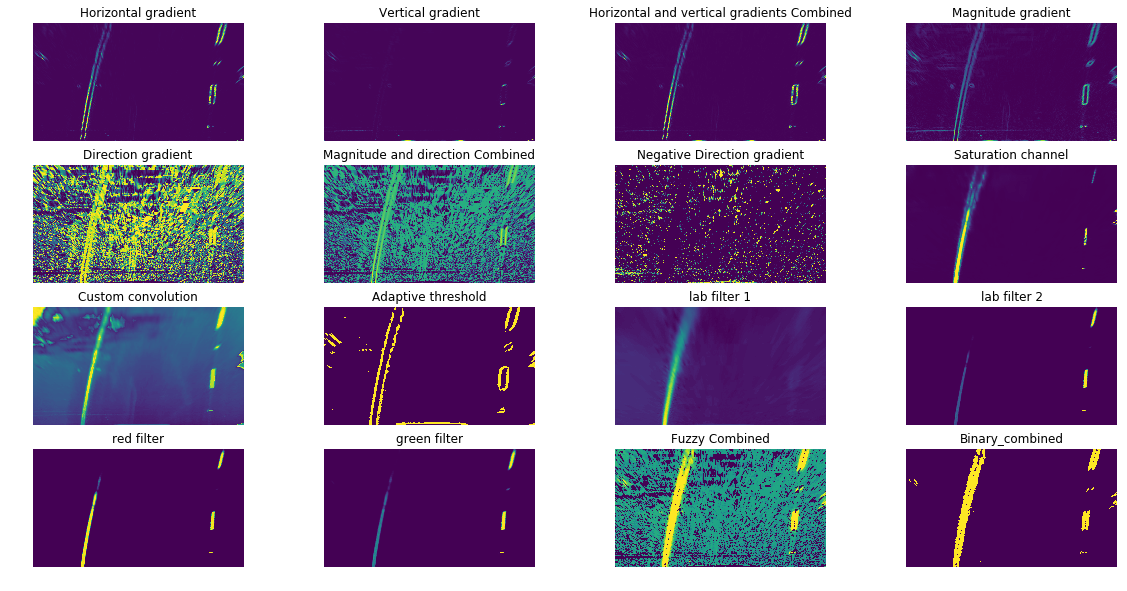

In [13]:
combined, _= combined_thresholds(bird_eye_view, display = True)

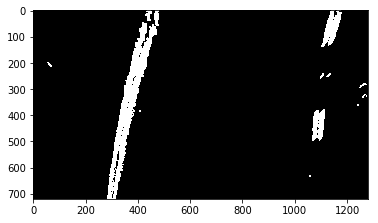

In [14]:
kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(combined, cv2.MORPH_OPEN, kernel)
plt.imshow(opening, cmap = 'gray')

In [15]:
class Line():
    offset = 0
    def __init__(self, color = None):
        # was the line detected in the last iteration?
        self.confidence = 0
        self.detected = False
        self.detected = False  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        self.x_points = None
        self.y_points = None
        
        self.all_coef = deque([], maxlen = 10)

        
        self.poly = None
        
        self.image = None
        self.color = color

        
    def coef_update(self, new_coef):
        self.detected = True
        self.all_coef.append(new_coef)
        
    def get_median_coef(self):
        return np.median(self.all_coef, axis = 0)

In [16]:
lines = {'left': Line('red'), 'right':Line('blue')}

In [17]:
def find_lane_lines(binary_image, line, mean, windows_height = 25, min_width = 75, max_width = 150, display = False):
    if display:
        fig = plt.figure(figsize = (20,10))
        ax1 = fig.add_subplot(121)
        #ax2 = fig.add_subplot(122, projection='3d')
        ax1.imshow(binary_image, cmap = 'gray')
    windows_width = max_width
    line_image = np.zeros_like(binary_image)
    if display:
        sequence = tqdm(range(binary_image.shape[0],0,-windows_height))
    else:
        sequence = range(binary_image.shape[0],0,-windows_height)
    for i in sequence:
        if ((mean-windows_width)<0) or ((mean+windows_width)>binary_image.shape[1]):            
            break

        x = np.linspace(0,binary_image.shape[1]-1,binary_image.shape[1],dtype = 'int')
        x = x[mean-windows_width:mean+windows_width]
        y = np.sum(binary_image[i-windows_height:i,mean-windows_width:mean+windows_width], axis = 0)
        window = gaussmf(np.linspace(0,windows_width, len(y)), mean = windows_width/2, sigma = 1.5*windows_width)
        if display:
            ax1.plot(mean, i-windows_height/2,'*')
            ax1.add_patch(patches.Rectangle((mean-windows_width,i-windows_height), 2*windows_width,windows_height, fill = False,edgecolor=line.color))
        if len(y)>0:
            search = np.multiply(window,y)
            if np.max(y)>5: 
                mean = int(x[int(np.median(np.argwhere(search==np.max(search))))])
                windows_width = max(min_width, windows_width-50)
            else:
                windows_width = min(max_width, windows_width+10)
        line_image[i-windows_height:i,mean-windows_width:mean+windows_width] = binary_image[i-windows_height:i,mean-windows_width:mean+windows_width]    
        if display:
            pass
            #ax2.bar(x,search,i,zdir='x',width = 1/1.5)
        line.image = line_image
        line.y_points, line.x_points = np.nonzero(line.image)

100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 68.73it/s]


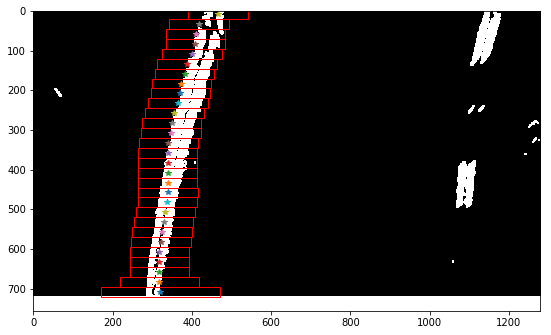

In [18]:
find_lane_lines(opening, lines['left'], opening.shape[1]*0.25, windows_height = 25, display = True)

100%|██████████████████████████████████████████| 29/29 [00:00<00:00, 71.59it/s]


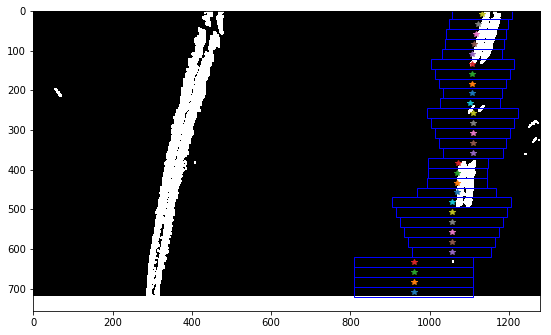

In [19]:
find_lane_lines(opening, lines['right'], opening.shape[1]*0.75, windows_height = 25, display = True)

In [20]:
def find_lane_lines_with_coef(binary_image, line, margin = 100):
    fit_coef = line.get_median_coef()
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    lane_inds = ((nonzerox > (fit_coef[0]*(nonzeroy**2) + fit_coef[1]*nonzeroy + fit_coef[2] - margin)) & (nonzerox < (fit_coef[0]*(nonzeroy**2) + fit_coef[1]*nonzeroy + fit_coef[2] + margin))) 
    line.x_points = nonzerox[lane_inds]
    line.y_points = nonzeroy[lane_inds] 

        

In [ ]:
def fit_lines(input_img, lines):
    if (lines['left'].detected == False):      
        find_lane_lines(input_img, lines['left'], input_img.shape[1]*0.25)
    else:
        find_lane_lines_with_coef(input_img, lines['left'])
        
    if (lines['right'].detected == False):
        find_lane_lines(input_img, lines['right'], input_img.shape[1]*0.75)
    else:
        find_lane_lines_with_coef(input_img, lines['right'])
        
    if len(lines['left'].x_points)>0:
        left_new_coef = np.polyfit(lines['left'].y_points,lines['left'].x_points,2)
    if len(lines['right'].x_points)>0:
        right_new_coef = np.polyfit(lines['right'].y_points,lines['right'].x_points,2)
    if len(lines['left'].x_points)>0 and len(lines['right'].x_points)>0:
        if (np.abs(left_new_coef[0]-right_new_coef[0])<1e-3)and(np.abs(left_new_coef[1]-right_new_coef[1])<0.5):
            lines['left'].coef_update(left_new_coef)
            lines['right'].coef_update(right_new_coef)
        else:
            lines['left'].detected = False
            lines['right'].detected = False
    lines['left'].poly = np.poly1d(lines['left'].get_median_coef())
    lines['right'].poly = np.poly1d(lines['right'].get_median_coef())
fit_lines(opening, lines)

In [22]:
def retrive_curvature_and_offset(lines, y_eval, xm_per_pix = 3.7/700,ym_per_pix = 30/720):
    # Fit new polynomials to x,y in world space
    if len(lines['left'].x_points)>0:
        left_fit_cr = np.polyfit(lines['left'].y_points*ym_per_pix,lines['left'].x_points*xm_per_pix, 2)
        lines['left'].radius_of_curvature = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])

    if len(lines['right'].x_points)>0:
        right_fit_cr = np.polyfit(lines['right'].y_points*ym_per_pix,lines['right'].x_points*xm_per_pix, 2)
        lines['right'].radius_of_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    if (len(lines['left'].x_points)>0) and (len(lines['right'].x_points)>0):
        Line.offset = (img.shape[1]/2-(lines['right'].poly(img.shape[0])+lines['left'].poly(img.shape[0]))/2)*xm_per_pix*100
    return lines['left'].radius_of_curvature, lines['right'].radius_of_curvature, Line.offset
left_curverad, right_curverad, offset = retrive_curvature_and_offset(lines,h)
print(left_curverad, right_curverad, offset )

1162.74725619 1135.06347097 -25.5311494109


In [ ]:
y_points = np.linspace(0,h, 100)

plt.figure(figsize = (20,10))
axes = plt.gca()
axes.set_xlim([0,1280])
axes.set_ylim([720,0])
plt.imshow(bird_eye_view)
plt.plot(lines['left'].poly(y_points),y_points,  linewidth = 10, color = 'b' )
plt.plot(lines['right'].poly(y_points),y_points, linewidth = 10, color = 'y')
plt.show()


In [24]:
def get_virtual_lane(input_image, lines):
    output_image = np.zeros_like(input_image).astype(np.uint8)    
    pts_left = np.array([np.transpose(np.vstack([lines['left'].poly(y_points), y_points]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([lines['right'].poly(y_points), y_points])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(output_image, np.int_([pts]), (55,174, 105))
    return cv2.warpPerspective(output_image, Minv, (output_image.shape[1], output_image.shape[0]))

def get_lanes_lines_mask(input_image, lines, width = 20):

    output_image = np.zeros(input_image.shape[0:2])
    pts_left_border_1 = np.array([np.transpose([lines['left'].poly(y_points)- width, y_points])])
    pts_left_border_2 = np.array([np.flipud(np.transpose([lines['left'].poly(y_points) + width, y_points]))])
    left_border_points = np.hstack((pts_left_border_1,pts_left_border_2))
    cv2.fillPoly(output_image, np.int_([left_border_points]), 1)
    pts_right_border_1 = np.array([np.transpose([lines['right'].poly(y_points)-width, y_points])])
    pts_right_border_2 = np.array([np.flipud(np.transpose([lines['right'].poly(y_points)+width, y_points]))])
    right_border_points = np.hstack((pts_right_border_1,pts_right_border_2))
    cv2.fillPoly(output_image, np.int_([right_border_points]),1)
    return cv2.warpPerspective(output_image, Minv, (output_image.shape[1], output_image.shape[0]))

def overlay_text(input_image, left_curverad,right_curverad,offset):
    text1 = 'Curve radius: ' + '{:.0f} m'.format(np.mean([left_curverad,right_curverad]))
    text2 = 'Offset: ' + '{:.2f} cm'.format(offset) 
    cv2.putText(input_image, text1, (550,625), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (10,25,20),2)
    cv2.putText(input_image, text2, (550,650), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (10,25,20),2)

In [25]:
lines = {'left': Line('left'), 'right':Line('right')}
def process_video(frame):
    undist = undistort(frame)
    bird_eye_view = change_to_bird_eye(undist, M)
    combined, combined_fuzzy = combined_thresholds(bird_eye_view)
    small_combined_fuzzy = cv2.resize(combined_fuzzy, (128,72))
    small_combined_binary = cv2.resize(combined, (128,72))
    opening = cv2.morphologyEx(combined, cv2.MORPH_OPEN, kernel)
    fit_lines(opening, lines)
    left_curverad, right_curverad, offset = retrive_curvature_and_offset(lines,h)
    lane_overlay = get_virtual_lane(frame,lines)
    lane_lines_overlay = get_lanes_lines_mask(frame, lines)
    result = cv2.addWeighted(frame, 1, lane_overlay, 0.3, 0)
    result[np.nonzero(lane_lines_overlay)] = [0,0, 255]
    overlay_text(result, left_curverad,right_curverad,offset)
    
    result[0:72,0:128] = cv2.cvtColor((255*small_combined_fuzzy).astype('uint8'), cv2.COLOR_GRAY2RGB)
    result[0:72,128:256] = cv2.cvtColor(255*small_combined_binary.astype('uint8'), cv2.COLOR_GRAY2RGB)
    return result
    

0 False


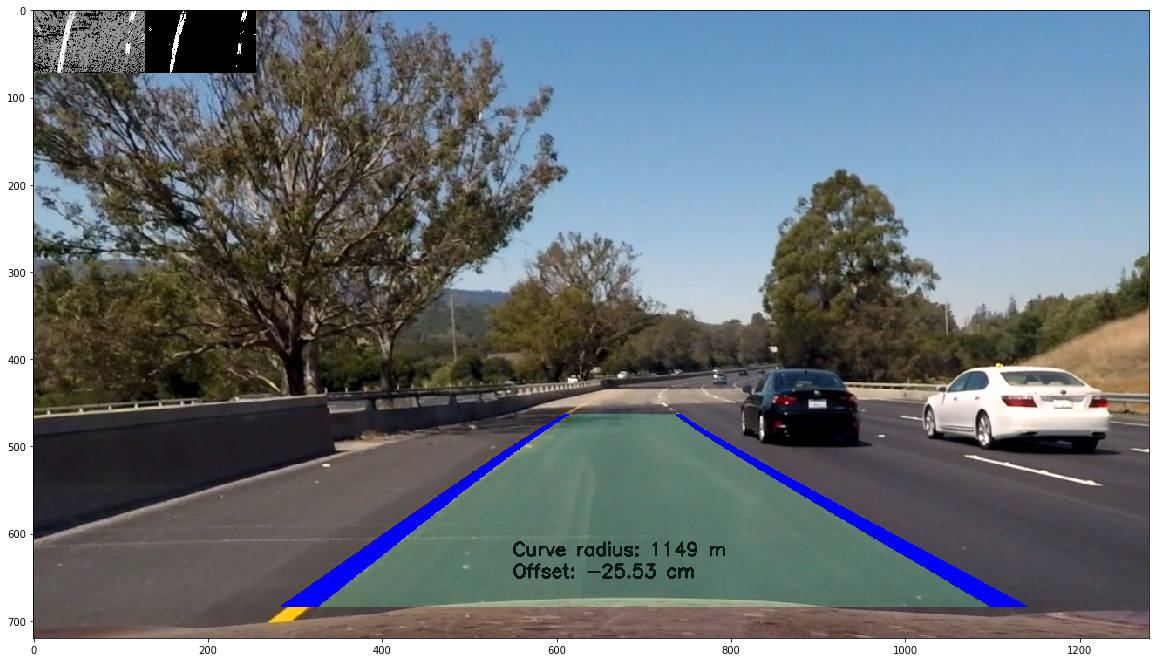

In [26]:
img = undistort(cv2.imread(os.path.join(os.getcwd(), test_images_path, 'test6.jpg')))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
lines = {'left': Line(), 'right':Line()}
plt.imshow(process_video(img))

In [64]:
lines = {'left': Line('red'), 'right':Line('blue')}
write_output = 'video_output1.mp4'
clip1 = VideoFileClip("project_video_cut.mp4")
write_clip = clip1.fl_image(process_video)
%time write_clip.write_videofile(write_output, audio=False)


0 False
0.0971718763782
[MoviePy] >>>> Building video video_output1.mp4
[MoviePy] Writing video video_output1.mp4



  0%|                                                   | 0/19 [00:00<?, ?it/s]

1 True
0.124134325264



  5%|██▎                                        | 1/19 [00:01<00:23,  1.31s/it]

2 True
0.124032420866



 11%|████▌                                      | 2/19 [00:02<00:22,  1.30s/it]

3 True
0.0964589504035



 16%|██████▊                                    | 3/19 [00:03<00:20,  1.30s/it]

4 True
0.0978208538444



 21%|█████████                                  | 4/19 [00:05<00:19,  1.29s/it]

5 True
0.126159468135



 26%|███████████▎                               | 5/19 [00:06<00:18,  1.29s/it]

6 True
0.0795149780172



 32%|█████████████▌                             | 6/19 [00:07<00:16,  1.29s/it]

7 True
0.0960144044141



 37%|███████████████▊                           | 7/19 [00:08<00:15,  1.28s/it]

8 True
0.116567161913



 42%|██████████████████                         | 8/19 [00:10<00:14,  1.28s/it]

9 True
0.136756173182



 47%|████████████████████▎                      | 9/19 [00:11<00:12,  1.29s/it]

10 True
0.150219801553



 53%|██████████████████████                    | 10/19 [00:12<00:11,  1.30s/it]

10 True
0.145817070723



 58%|████████████████████████▎                 | 11/19 [00:14<00:10,  1.29s/it]

10 True
0.121542966608



 63%|██████████████████████████▌               | 12/19 [00:15<00:08,  1.28s/it]

10 True
0.112236135234



 68%|████████████████████████████▋             | 13/19 [00:16<00:07,  1.28s/it]

10 True
0.0929911600496



 74%|██████████████████████████████▉           | 14/19 [00:17<00:06,  1.28s/it]

10 True
0.0709469263371



 79%|█████████████████████████████████▏        | 15/19 [00:19<00:05,  1.28s/it]

10 True
0.0489307262886



 84%|███████████████████████████████████▎      | 16/19 [00:20<00:03,  1.27s/it]

10 True
0.0411384952665



 89%|█████████████████████████████████████▌    | 17/19 [00:21<00:02,  1.29s/it]

10 True
0.081321475978



 95%|███████████████████████████████████████▊  | 18/19 [00:23<00:01,  1.29s/it]

10 True
0.0982230019586



100%|██████████████████████████████████████████| 19/19 [00:24<00:00,  1.29s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output1.mp4 

Wall time: 25.1 s


In [43]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('video_output1.mp4'))

In [ ]:
lines = {'left': Line(), 'right':Line()}
write_output = 'video_output2.mp4'
clip1 = VideoFileClip("project_video.mp4")
write_clip = clip1.fl_image(process_video)
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video video_output2.mp4
[MoviePy] Writing video video_output2.mp4



 65%|█████████████████████████▍             | 824/1261 [17:28<09:45,  1.34s/it]

In [60]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('video_output2.mp4'))

In [31]:
lines = {'left': Line(), 'right':Line()}
write_output = 'video_output3.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
write_clip = clip1.fl_image(process_video)
%time write_clip.write_videofile(write_output, audio=False)

0 False
[MoviePy] >>>> Building video video_output3.mp4
[MoviePy] Writing video video_output3.mp4


  0%|                                                  | 0/485 [00:00<?, ?it/s]

1 True


  0%|                                          | 1/485 [00:01<09:50,  1.22s/it]

1 False


  0%|▏                                         | 2/485 [00:02<11:05,  1.38s/it]

2 True


  1%|▎                                         | 3/485 [00:04<10:53,  1.36s/it]

2 False


  1%|▎                                         | 4/485 [00:06<11:49,  1.47s/it]

3 True


  1%|▍                                         | 5/485 [00:07<11:18,  1.41s/it]

3 False


  1%|▌                                         | 6/485 [00:09<12:16,  1.54s/it]

4 True


  1%|▌                                         | 7/485 [00:10<11:38,  1.46s/it]

4 False


  2%|▋                                         | 8/485 [00:12<12:29,  1.57s/it]

5 True


  2%|▊                                         | 9/485 [00:13<11:39,  1.47s/it]

5 False


  2%|▊                                        | 10/485 [00:15<12:21,  1.56s/it]

6 True


  2%|▉                                        | 11/485 [00:16<11:32,  1.46s/it]

6 False


  2%|█                                        | 12/485 [00:18<12:09,  1.54s/it]

7 True


  3%|█                                        | 13/485 [00:19<11:28,  1.46s/it]

7 False


  3%|█▏                                       | 14/485 [00:21<12:07,  1.54s/it]

8 True


  3%|█▎                                       | 15/485 [00:22<11:24,  1.46s/it]

8 False


  3%|█▎                                       | 16/485 [00:24<12:03,  1.54s/it]

9 True


  4%|█▍                                       | 17/485 [00:25<11:20,  1.45s/it]

9 False


  4%|█▌                                       | 18/485 [00:27<12:02,  1.55s/it]

10 True


  4%|█▌                                       | 19/485 [00:28<11:20,  1.46s/it]

10 False


  4%|█▋                                       | 20/485 [00:30<12:03,  1.56s/it]

10 True


  4%|█▊                                       | 21/485 [00:31<11:21,  1.47s/it]

10 False


  5%|█▊                                       | 22/485 [00:33<12:02,  1.56s/it]

10 True


  5%|█▉                                       | 23/485 [00:34<11:19,  1.47s/it]

10 False


  5%|██                                       | 24/485 [00:36<11:56,  1.55s/it]

10 True


  5%|██                                       | 25/485 [00:37<11:11,  1.46s/it]

10 False


  5%|██▏                                      | 26/485 [00:39<11:51,  1.55s/it]

10 True


  6%|██▎                                      | 27/485 [00:40<11:07,  1.46s/it]

10 False


  6%|██▎                                      | 28/485 [00:42<11:46,  1.55s/it]

10 True


  6%|██▍                                      | 29/485 [00:43<11:02,  1.45s/it]

10 False


  6%|██▌                                      | 30/485 [00:45<11:42,  1.54s/it]

10 True


  6%|██▌                                      | 31/485 [00:46<11:04,  1.46s/it]

10 False


  7%|██▋                                      | 32/485 [00:48<11:40,  1.55s/it]

10 True


  7%|██▊                                      | 33/485 [00:49<11:01,  1.46s/it]

10 False


  7%|██▊                                      | 34/485 [00:51<11:40,  1.55s/it]

10 True


  7%|██▉                                      | 35/485 [00:52<10:57,  1.46s/it]

10 False


  7%|███                                      | 36/485 [00:54<11:33,  1.55s/it]

10 True


  8%|███▏                                     | 37/485 [00:55<10:53,  1.46s/it]

10 False


  8%|███▏                                     | 38/485 [00:57<11:29,  1.54s/it]

10 True


  8%|███▎                                     | 39/485 [00:58<10:50,  1.46s/it]

10 False


  8%|███▍                                     | 40/485 [01:00<11:28,  1.55s/it]

10 True


  8%|███▍                                     | 41/485 [01:01<10:50,  1.46s/it]

10 False


  9%|███▌                                     | 42/485 [01:03<11:23,  1.54s/it]

10 True


  9%|███▋                                     | 43/485 [01:04<10:48,  1.47s/it]

10 False


  9%|███▋                                     | 44/485 [01:06<11:24,  1.55s/it]

10 True


  9%|███▊                                     | 45/485 [01:07<10:44,  1.47s/it]

10 False


  9%|███▉                                     | 46/485 [01:09<11:18,  1.55s/it]

10 True


 10%|███▉                                     | 47/485 [01:10<10:41,  1.46s/it]

10 False


 10%|████                                     | 48/485 [01:12<11:19,  1.55s/it]

10 True


 10%|████▏                                    | 49/485 [01:13<10:42,  1.47s/it]

10 False


 10%|████▏                                    | 50/485 [01:15<11:19,  1.56s/it]

10 True


 11%|████▎                                    | 51/485 [01:16<10:36,  1.47s/it]

10 False


 11%|████▍                                    | 52/485 [01:18<11:12,  1.55s/it]

10 True


 11%|████▍                                    | 53/485 [01:19<10:36,  1.47s/it]

10 False


 11%|████▌                                    | 54/485 [01:21<11:12,  1.56s/it]

10 True


 11%|████▋                                    | 55/485 [01:22<10:34,  1.48s/it]

10 False


 12%|████▋                                    | 56/485 [01:24<11:10,  1.56s/it]

10 True


 12%|████▊                                    | 57/485 [01:25<10:29,  1.47s/it]

10 False


 12%|████▉                                    | 58/485 [01:27<11:07,  1.56s/it]

10 True


 12%|████▉                                    | 59/485 [01:28<10:29,  1.48s/it]

10 False


 12%|█████                                    | 60/485 [01:30<11:03,  1.56s/it]

10 True


 13%|█████▏                                   | 61/485 [01:31<10:24,  1.47s/it]

10 False


 13%|█████▏                                   | 62/485 [01:33<10:57,  1.55s/it]

10 True


 13%|█████▎                                   | 63/485 [01:34<10:19,  1.47s/it]

10 False


 13%|█████▍                                   | 64/485 [01:36<10:51,  1.55s/it]

10 True


 13%|█████▍                                   | 65/485 [01:37<10:17,  1.47s/it]

10 False


 14%|█████▌                                   | 66/485 [01:39<10:52,  1.56s/it]

10 True


 14%|█████▋                                   | 67/485 [01:40<10:19,  1.48s/it]

10 False


 14%|█████▋                                   | 68/485 [01:42<10:49,  1.56s/it]

10 True


 14%|█████▊                                   | 69/485 [01:43<10:09,  1.47s/it]

10 False


 14%|█████▉                                   | 70/485 [01:45<10:45,  1.56s/it]

10 True


 15%|██████                                   | 71/485 [01:46<10:06,  1.47s/it]

10 False


 15%|██████                                   | 72/485 [01:48<10:47,  1.57s/it]

10 True


 15%|██████▏                                  | 73/485 [01:50<10:13,  1.49s/it]

10 False


 15%|██████▎                                  | 74/485 [01:51<10:48,  1.58s/it]

10 True


 15%|██████▎                                  | 75/485 [01:53<10:10,  1.49s/it]

10 False


 16%|██████▍                                  | 76/485 [01:54<10:41,  1.57s/it]

10 True


 16%|██████▌                                  | 77/485 [01:56<10:05,  1.48s/it]

10 False


 16%|██████▌                                  | 78/485 [01:57<10:37,  1.57s/it]

10 True


 16%|██████▋                                  | 79/485 [01:59<10:02,  1.48s/it]

10 False


 16%|██████▊                                  | 80/485 [02:01<10:47,  1.60s/it]

10 True


 17%|██████▊                                  | 81/485 [02:02<10:13,  1.52s/it]

10 False


 17%|██████▉                                  | 82/485 [02:04<10:39,  1.59s/it]

10 True


 17%|███████                                  | 83/485 [02:05<10:03,  1.50s/it]

10 False


 17%|███████                                  | 84/485 [02:07<10:34,  1.58s/it]

10 True


 18%|███████▏                                 | 85/485 [02:08<09:52,  1.48s/it]

10 False


 18%|███████▎                                 | 86/485 [02:10<10:22,  1.56s/it]

10 True


 18%|███████▎                                 | 87/485 [02:11<09:42,  1.46s/it]

10 False


 18%|███████▍                                 | 88/485 [02:13<10:13,  1.54s/it]

10 True


 18%|███████▌                                 | 89/485 [02:14<09:32,  1.45s/it]

10 False


 19%|███████▌                                 | 90/485 [02:16<10:04,  1.53s/it]

10 True


 19%|███████▋                                 | 91/485 [02:17<09:28,  1.44s/it]

10 False


 19%|███████▊                                 | 92/485 [02:19<10:04,  1.54s/it]

10 True


 19%|███████▊                                 | 93/485 [02:20<09:33,  1.46s/it]

10 False


 19%|███████▉                                 | 94/485 [02:22<10:18,  1.58s/it]

10 True


 20%|████████                                 | 95/485 [02:23<09:47,  1.51s/it]

10 False


 20%|████████                                 | 96/485 [02:25<10:16,  1.58s/it]

10 True


 20%|████████▏                                | 97/485 [02:26<09:51,  1.52s/it]

10 False


 20%|████████▎                                | 98/485 [02:28<10:22,  1.61s/it]

10 True


 20%|████████▎                                | 99/485 [02:29<09:43,  1.51s/it]

10 False


 21%|████████▏                               | 100/485 [02:31<10:15,  1.60s/it]

10 True


 21%|████████▎                               | 101/485 [02:32<09:37,  1.50s/it]

10 False


 21%|████████▍                               | 102/485 [02:34<10:04,  1.58s/it]

10 True


 21%|████████▍                               | 103/485 [02:36<09:29,  1.49s/it]

10 False


 21%|████████▌                               | 104/485 [02:37<09:59,  1.57s/it]

10 True


 22%|████████▋                               | 105/485 [02:39<09:25,  1.49s/it]

10 False


 22%|████████▋                               | 106/485 [02:40<09:52,  1.56s/it]

10 True


 22%|████████▊                               | 107/485 [02:42<09:16,  1.47s/it]

10 False


 22%|████████▉                               | 108/485 [02:43<09:47,  1.56s/it]

10 True


 22%|████████▉                               | 109/485 [02:45<09:15,  1.48s/it]

10 False


 23%|█████████                               | 110/485 [02:46<09:46,  1.56s/it]

10 True


 23%|█████████▏                              | 111/485 [02:48<09:18,  1.49s/it]

10 False


 23%|█████████▏                              | 112/485 [02:50<09:48,  1.58s/it]

10 True


 23%|█████████▎                              | 113/485 [02:51<09:12,  1.49s/it]

10 False


 24%|█████████▍                              | 114/485 [02:53<09:40,  1.56s/it]

10 True


 24%|█████████▍                              | 115/485 [02:54<09:06,  1.48s/it]

10 False


 24%|█████████▌                              | 116/485 [02:56<09:32,  1.55s/it]

10 True


 24%|█████████▋                              | 117/485 [02:57<08:58,  1.46s/it]

10 False


 24%|█████████▋                              | 118/485 [02:59<09:29,  1.55s/it]

10 True


 25%|█████████▊                              | 119/485 [03:00<08:57,  1.47s/it]

10 False


 25%|█████████▉                              | 120/485 [03:02<09:24,  1.55s/it]

10 True


UnboundLocalError: local variable 'right_new_coef' referenced before assignment

In [ ]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('video_output3.mp4'))

In [ ]:
lines = {'left': Line(), 'right':Line()}
write_output = 'video_output4.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
write_clip = clip1.fl_image(process_video)
%time write_clip.write_videofile(write_output, audio=False)

In [ ]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('video_output4.mp4'))